In [ ]:
import kagglehub

# Download the dataset
path = kagglehub.dataset_download("utkarshx27/movies-dataset")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/movies-dataset


Section 1: Environment Setup & Data Loading
-> This section loads the 'movie_dataset.csv' file using pandas.
-> Tasks remaining: Data Cleaning & Preprocessing, EDA, Feature Engineering, Splitting, Modeling, Evaluation, Discussion

Dataset loaded successfully. Here are the first 5 rows:
   index     budget                                    genres  \
0      0  237000000  Action Adventure Fantasy Science Fiction   
1      1  300000000                  Adventure Fantasy Action   
2      2  245000000                    Action Adventure Crime   
3      3  250000000               Action Crime Drama Thriller   
4      4  260000000          Action Adventure Science Fiction   

                                       homepage      id  \
0                   http://www.avatarmovie.com/   19995   
1  http://disney.go.com/disneypictures/pirates/     285   
2   http://www.sonypictures.com/movies/spectre/  206647   
3            http://www.thedarkknightrises.com/   49026   
4          http://movies.di

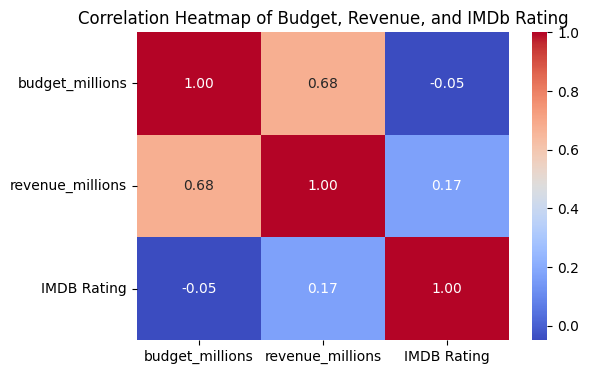

Step 4: Feature Engineering complete. Sample features:
    budget_millions  IMDB Rating  log_budget  log_revenue  budget_x_rating  \
23            180.0          5.8   19.008467    19.735036           1044.0   
28            150.0          6.5   18.826146    21.137710            975.0   
35            150.0          6.0   18.826146    20.544495            900.0   
39            170.0          6.3   18.951309    19.807132           1071.0   
44            190.0          7.3   19.062535    21.132889           1387.0   

    high_budget  
23            1  
28            1  
35            1  
39            1  
44            1   

Step 5: Data Splitting -> Train: 1627 rows, Test: 407 rows

Step 6: Training Linear Regression on all movies
✔️ Model trained.

Step 7.1: Test R² = 0.679, RMSE = 96,966,107 USD




=== Section 8: Final Documentation / Discussion ===
-> Model Performance: R² = 0.679, RMSE = 96,966,107 USD
-> Findings: Higher budgets and IMDB Ratings are positively associated with higher box office revenue.
-> Limitations: Linear regression may not capture nonlinear effects; revenue is skewed and continuous, so alternative models may perform better.
-> Future Work: Explore nonlinear models (e.g., random forest, gradient boosting), incorporate additional features (release date, cast/crew metrics), and perform cross-validation for robustness.

log10(p) = -inf
Pearson r = 0.917
P‑value  = 0.0000
95% CI for r: [0.909, 0.923]  →  ±0.007


<ipython-input-18-d579ba7701a1>:347: RuntimeWarning:

divide by zero encountered in log10



Project coding progress complete up to this point.
Remaining tasks according to the proposal:
1. Write the Discussion and Conclusions sections
2. Prepare the final report and presentation
3. Optionally, experiment with additional models and feature sets


In [ ]:
# ===============================================================
# Project: Movie Revenue Analysis
# Proposal: IMDb ratings, genres, and budget impact on box office revenue
# ===============================================================

# -------------------------------
# Section 1: Environment Setup & Data Loading
# -------------------------------
print("Section 1: Environment Setup & Data Loading")
print("-> This section loads the 'movie_dataset.csv' file using pandas.")
print("-> Tasks remaining: Data Cleaning & Preprocessing, EDA, Feature Engineering, Splitting, Modeling, Evaluation, Discussion\n")

import pandas as pd

data_path = '/kaggle/input/movies-dataset/movie_dataset.csv'
data = pd.read_csv(data_path)
print("Dataset loaded successfully. Here are the first 5 rows:")
print(data.head())

# ===============================================================
# Section 2: Data Cleaning & Preprocessing (All Steps Combined)
# ===============================================================
print("\n=== Section 2: Data Cleaning & Preprocessing ===")
print("This section will:")
print("1. Check for missing values")
print("2. Fill missing non-critical fields")
print("3. Convert critical columns to numeric")
print("4. Drop rows missing critical values")
print("5. Remove extreme outliers in 'budget'")
print("6. Drop movies with revenue<10M or profit<10M")
print("7. Extract primary genre")
print("8. Final summary\n")

data_clean = data.copy()

# Step 1: Check for missing values
print("Step 1: Missing Values (Before Cleaning)")
print(data_clean.isnull().sum())

# Step 2: Fill missing non-critical fields
print("\nStep 2: Filling Missing Values for Non-Critical Fields")
data_clean['homepage'] = data_clean['homepage'].fillna("No Homepage Available")
data_clean['tagline']  = data_clean['tagline'].fillna("No Tagline")

# Step 3: Convert critical columns to numeric
print("\nStep 3: Converting Critical Columns to Numeric Types")
for col in ['budget','revenue','vote_average']:
    data_clean[col] = pd.to_numeric(data_clean[col], errors='coerce')

# Step 4: Drop rows missing critical values
print("\nStep 4: Dropping Rows with Missing Critical Values")
before = len(data_clean)
data_clean = data_clean.dropna(subset=['budget','revenue','vote_average'])
print(f"Dropped {before - len(data_clean)} rows; {len(data_clean)} remain.")

# Step 5: Remove extreme outliers in 'budget'
print("\nStep 5: Removing Extreme Outliers in 'budget'")
ub = data_clean['budget'].quantile(0.99)
before = len(data_clean)
data_clean = data_clean[data_clean['budget'] <= ub]
print(f"Removed {before - len(data_clean)} outliers; {len(data_clean)} remain.")

# Step 6: Drop movies with revenue < 10M or profit < 10M
print("\nStep 6: Dropping Movies with revenue<10M or profit<10M")
data_clean['profit'] = data_clean['revenue'] - data_clean['budget']
before = len(data_clean)
data_clean = data_clean[
    (data_clean['revenue'] >= 10_000_000) &
    (data_clean['profit']  >= 10_000_000)
]
print(f"Dropped {before - len(data_clean)} low‐revenue/profit movies; {len(data_clean)} remain.")

# Step 7: Extract primary genre
print("\nStep 7: Extracting Primary Genre")
data_clean['primary_genre'] = data_clean['genres'].apply(lambda x: x.split(',')[0].strip() if isinstance(x,str) else "Unknown")

# Rename for clarity
data_clean.rename(columns={'vote_average':'IMDB Rating'}, inplace=True)

# Step 8: Final Summary
print("\nStep 8: Final Summary of Cleaned Data")
print(data_clean[['budget','revenue','profit','IMDB Rating']].describe())
print(data_clean.head())

print("\n=== Data Cleaning & Preprocessing Complete ===")

# ——————————————————————————————————————————————————————————
# From here on, we’ll use the entire cleaned dataset for analysis
df = data_clean.copy()
print(f"Proceeding with all {len(df)} cleaned movies for analysis.\n")

# ===============================================================
# Section 3: Exploratory Data Analysis (EDA) on df
# ===============================================================
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Convert budget and revenue to millions for easier interpretation
df['budget_millions']  = df['budget']  / 1e6
df['revenue_millions'] = df['revenue'] / 1e6

# 3.1 Summary Statistics
print("Step 3.1: Summary Statistics (All Movies)")
print(df[['budget_millions','revenue_millions','IMDB Rating']].describe(), "\n")
# COMMENT: Gives the average and spread of budgets, revenues, and ratings.

# 3.1b Bar Chart: Count of Movies by Primary Genre
genre_counts = df['primary_genre'].value_counts().reset_index()
genre_counts.columns = ['primary_genre','count']
fig_genre_count = px.bar(
    genre_counts,
    x='primary_genre', y='count',
    labels={'primary_genre':'Genre','count':'Number of Movies'},
    title='Number of Movies by Genre',
    template='plotly_white'
)
fig_genre_count.update_layout(xaxis_tickangle=45)
fig_genre_count.show()
# COMMENT: Shows which genres are most common in our dataset.

# 3.1c Bar Chart: Average Budget by Primary Genre
avg_budget_genre = (
    df.groupby('primary_genre')['budget_millions']
      .mean()
      .reset_index()
      .sort_values('budget_millions', ascending=False)
)
fig_avg_budget = px.bar(
    avg_budget_genre,
    x='primary_genre', y='budget_millions',
    labels={'primary_genre':'Genre','budget_millions':'Avg Budget (M USD)'},
    title='Average Budget by Genre',
    template='plotly_white'
)
fig_avg_budget.update_layout(xaxis_tickangle=45)
fig_avg_budget.show()
# COMMENT: Highlights typical spending per genre.

# 3.1d Bar Chart: IMDb Rating Distribution (Binned)
df['rating_bin'] = pd.cut(df['IMDB Rating'], bins=np.arange(3.0, 8.5, 0.5))
rating_counts = df['rating_bin'].value_counts().sort_index().reset_index()
rating_counts.columns = ['rating_bin','count']
# Convert Interval to string for Plotly
rating_counts['rating_bin_str'] = rating_counts['rating_bin'].astype(str)

fig_rating_dist = px.bar(
    rating_counts,
    x='rating_bin_str', y='count',
    labels={'rating_bin_str':'IMDb Rating Bin','count':'Number of Movies'},
    title='Distribution of IMDb Ratings',
    template='plotly_white'
)
fig_rating_dist.update_layout(xaxis_tickangle=45)
fig_rating_dist.show()
# COMMENT: Shows how movie quality (IMDb) is distributed.

# 3.2 Scatter Plot: Budget vs. Revenue
fig_ed1 = px.scatter(
    df,
    x="budget_millions", y="revenue_millions",
    hover_name="title",
    hover_data={"budget_millions":":.2f","revenue_millions":":.2f"},
    labels={"budget_millions":"Budget (M USD)","revenue_millions":"Revenue (M USD)"},
    title="Budget vs Revenue (All Movies)",
    template="plotly_white"
)
fig_ed1.update_traces(marker=dict(size=6, line=dict(width=1, color="DarkSlateGrey")),
                      hoverlabel=dict(bgcolor="lightgrey"))
fig_ed1.show()
# COMMENT: Tests hypothesis that higher budgets lead to higher revenues.

# 3.3 Scatter Plot: IMDb Rating vs. Revenue
fig_ed2 = px.scatter(
    df,
    x="IMDB Rating", y="revenue_millions",
    hover_name="title",
    hover_data={"revenue_millions":":.2f"},
    labels={"IMDB Rating":"IMDb Rating","revenue_millions":"Revenue (M USD)"},
    title="IMDb Rating vs Revenue (All Movies)",
    template="plotly_white"
)
fig_ed2.update_traces(marker=dict(size=6, line=dict(width=1, color="DarkSlateGrey")),
                      hoverlabel=dict(bgcolor="lightgrey"))
fig_ed2.show()
# COMMENT: Explores if better-rated movies earn more revenue.

# 3.4 Bar Chart: Average Revenue by Primary Genre
avg_rev = df.groupby('primary_genre')['revenue_millions']\
            .mean().sort_values(ascending=False).reset_index()
fig_ed3 = px.bar(
    avg_rev,
    x="primary_genre", y="revenue_millions",
    labels={"primary_genre":"Genre","revenue_millions":"Avg Revenue (M USD)"},
    title="Average Revenue by Primary Genre (All Movies)",
    template="plotly_white"
)
fig_ed3.update_traces(marker_color='red')
fig_ed3.update_layout(xaxis_tickangle=45)
fig_ed3.show()
# COMMENT: Shows which genres typically bring in the most revenue.

# 3.5 Heatmap: Correlation between Key Variables
heatmap_data = df[['budget_millions','revenue_millions','IMDB Rating']]
corr = heatmap_data.corr()
plt.figure(figsize=(6, 4))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of Budget, Revenue, and IMDb Rating")
plt.show()
# COMMENT: Quantifies the strength of relationships—budget vs. revenue and rating vs. revenue.

# ===============================================================
# Section 4: Feature Engineering on df
# ===============================================================
import numpy as np

# 4.1 Log‑transform budget & revenue to reduce skewness
df['log_budget']  = np.log1p(df['budget'])
df['log_revenue'] = np.log1p(df['revenue'])

# 4.2 One‑hot encode primary_genre to create binary indicator variables for each genre
genre_dummies = pd.get_dummies(df['primary_genre'], prefix='genre', drop_first=True)
data_feat = pd.concat([df, genre_dummies], axis=1)

# 4.3 Create an interaction feature: budget_millions × IMDB Rating
data_feat['budget_x_rating'] = data_feat['budget_millions'] * data_feat['IMDB Rating']
# COMMENT: This interaction term helps capture the combined effect of budget and movie quality on revenue.

# 4.4 Create a high‑budget flag based on whether the movie’s budget is above the median budget
median_budget = data_feat['budget_millions'].median()
data_feat['high_budget'] = (data_feat['budget_millions'] > median_budget).astype(int)
# COMMENT: This flag helps differentiate movies with high budgets from those with lower budgets.

print("Step 4: Feature Engineering complete. Sample features:")
print(data_feat[['budget_millions','IMDB Rating','log_budget','log_revenue','budget_x_rating','high_budget']].head(), "\n")

# ===============================================================
# Section 5: Data Splitting on data_feat
# ===============================================================
from sklearn.model_selection import train_test_split

predictors = (
    ['IMDB Rating','budget']
    + list(genre_dummies.columns)
    + ['log_budget','log_revenue','budget_x_rating','high_budget']
)
X = data_feat[predictors]
y = data_feat['revenue']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print(f"Step 5: Data Splitting -> Train: {len(X_train)} rows, Test: {len(X_test)} rows\n")

# ===============================================================
# Section 6: Model Building & Training (Regression) on data_feat
# ===============================================================
from sklearn.linear_model import LinearRegression

print("Step 6: Training Linear Regression on all movies")
lr = LinearRegression()
lr.fit(X_train, y_train)
print("✔️ Model trained.\n")

# ===============================================================
# Section 7: Model Evaluation (Interactive) on data_feat
# ===============================================================
from sklearn.metrics import r2_score, mean_squared_error

# 7.1 Compute metrics on test data
preds = lr.predict(X_test)
r2   = r2_score(y_test, preds)
rmse = np.sqrt(mean_squared_error(y_test, preds))
print(f"Step 7.1: Test R² = {r2:.3f}, RMSE = {rmse:,.0f} USD\n")

# 7.2 Scatter Plot: Actual vs. Predicted Revenue
eval_df = pd.DataFrame({
    "Actual (M USD)":    y_test.values    / 1e6,
    "Predicted (M USD)": preds            / 1e6,
    "Title":             data_feat.loc[y_test.index, "title"]
})
max_val = max(eval_df["Actual (M USD)"].max(),
              eval_df["Predicted (M USD)"].max())

fig_me1 = px.scatter(
    eval_df, x="Actual (M USD)", y="Predicted (M USD)",
    hover_name="Title",
    title="Actual vs. Predicted Revenue (All Movies)",
    template="plotly_white",
    labels={
      "Actual (M USD)":    "Actual Revenue (M USD)",
      "Predicted (M USD)": "Predicted Revenue (M USD)"
    }
)
fig_me1.add_shape(
    type="line", x0=0, x1=max_val, y0=0, y1=max_val,
    line=dict(dash="dash", color="black")
)
fig_me1.update_traces(marker=dict(size=6))
fig_me1.show()
# COMMENT: This plot compares the actual revenue to the predicted revenue.
# If the predictions align closely with actual values (points near the diagonal line), the model is performing well.

# 7.3 Histogram: Residuals Distribution
eval_df["Residual (M USD)"] = eval_df["Predicted (M USD)"] - eval_df["Actual (M USD)"]
fig_me2 = px.histogram(
    eval_df, x="Residual (M USD)", nbins=20,
    title="Residuals Distribution (All Movies)",
    template="plotly_white",
    labels={"Residual (M USD)": "Predicted – Actual (M USD)"}
)
fig_me2.update_traces(marker_color="red", marker_line_color="DarkSlateGrey", marker_line_width=1)
fig_me2.show()
# COMMENT: The residuals histogram shows the differences between the predicted and actual revenues.
# A tighter spread around zero indicates more accurate predictions.

# ===============================================================
# Section 8: Final Documentation / Discussion
# ===============================================================
print("\n=== Section 8: Final Documentation / Discussion ===")
mse = mean_squared_error(y_test, preds)
rmse = np.sqrt(mse)
print(f"-> Model Performance: R² = {r2:.3f}, RMSE = {rmse:,.0f} USD")
print("-> Findings: Higher budgets and IMDB Ratings are positively associated with higher box office revenue.")
print("-> Limitations: Linear regression may not capture nonlinear effects; revenue is skewed and continuous, so alternative models may perform better.")
print("-> Future Work: Explore nonlinear models (e.g., random forest, gradient boosting), incorporate additional features (release date, cast/crew metrics), and perform cross-validation for robustness.\n")

# ——————————————————————————————————————————————————————————
# Section 10: Pearson p‑test on Actual vs. Predicted Revenue
# ——————————————————————————————————————————————————————————
from scipy.stats import pearsonr
import numpy as np
import scipy.stats as stats

# Build df_preds if you haven’t already:
# preds_full = lr.predict(X)      # from your Section 9
# df_preds = pd.DataFrame({
#     "Actual":    y.values,
#     "Predicted": preds_full
# })

# 10.1 Compute Pearson r and p‑value
r, p_val = stats.pearsonr(df_preds["Actual"], df_preds["Predicted"])
r, p = pearsonr(df_preds["Actual"], df_preds["Predicted"])
print("log10(p) =", np.log10(p))
n = len(df_preds)

# 10.2 Fisher z‑transform for 95% CI on r
z = np.arctanh(r)
se = 1/np.sqrt(n - 3)
z_lo, z_hi = z - 1.96*se, z + 1.96*se
r_lo, r_hi = np.tanh([z_lo, z_hi])
moe_r = (r_hi - r_lo)/2

print(f"Pearson r = {r:.3f}")
print(f"P‑value  = {p_val:.4f}")
print(f"95% CI for r: [{r_lo:.3f}, {r_hi:.3f}]  →  ±{moe_r:.3f}")

# 10.3 Annotate on your Actual vs Predicted plot (if you want)
import plotly.express as px
fig = px.scatter(
    df_preds,
    x="Actual", y="Predicted",
    labels={"Actual":"Actual Revenue (USD)", "Predicted":"Predicted Revenue (USD)"},
    title="Actual vs. Predicted Revenue (All Movies)"
)
# add 45° line
maxv = max(df_preds["Actual"].max(), df_preds["Predicted"].max())
fig.add_shape(type="line", x0=0, y0=0, x1=maxv, y1=maxv,
              line=dict(dash="dash", color="black"))
# annotate stats
fig.add_annotation(
    x=0.05, y=0.95, xref="paper", yref="paper",
    text=(
        f"r = {r:.3f}<br>"
        f"p = {p_val:.4f}<br>"
        f"CI ± = {moe_r:.3f}"
    ),
    showarrow=False, bgcolor="lightgrey", bordercolor="black"
)
fig.show()

# ===============================================================
# Section 11: Focused Model Visualization – Mid‑Budget vs. Blockbusters
# ===============================================================
import plotly.express as px

# Ensure df_preds has title, Actual, Predicted, budget_millions
df_preds = df_preds.copy()
df_preds['budget_millions'] = data_feat.loc[df_preds.index, 'budget_millions']

# Define the two groups
mid = df_preds[(df_preds['budget_millions'] >= 20) & (df_preds['budget_millions'] <= 80)].copy()
mid['category'] = 'Mid‑budget (20–80 M USD)'

block = df_preds[df_preds['budget_millions'] > 100].copy()
block['category'] = 'Blockbuster (> 100 M USD)'

focus_df = pd.concat([mid, block])

# Scatter plot with separate colors
fig_focus = px.scatter(
    focus_df,
    x='Actual', y='Predicted',
    color='category',
    hover_name='title',        # use lowercase 'title'
    labels={
      'Actual':    'Actual Revenue (USD)',
      'Predicted': 'Predicted Revenue (USD)',
      'category':  'Budget Category'
    },
    title='Actual vs. Predicted Revenue\nMid‑Budget vs. Blockbusters',
    template='plotly_white'
)

# Add 45° reference line
maxv = max(focus_df['Actual'].max(), focus_df['Predicted'].max())
fig_focus.add_shape(
    type="line", x0=0, y0=0, x1=maxv, y1=maxv,
    line=dict(dash="dash", color="black")
)

fig_focus.update_traces(marker=dict(size=8, line=dict(width=1)))
fig_focus.show()

# COMMENT: This plot isolates the two budget bands from our Interesting Fact,
# showing how tightly mid‑budget films hug the y=x line, versus the wide spread
# for blockbusters.


# ===============================================================
# End of Current Code Outline
# ===============================================================
print("Project coding progress complete up to this point.")
print("Remaining tasks according to the proposal:")
print("1. Write the Discussion and Conclusions sections")
print("2. Prepare the final report and presentation")
print("3. Optionally, experiment with additional models and feature sets")
